# TGA余额与流动性注入

TGA（Treasury General Account，财政部一般账号），美国政府（财政部）在美联储的存款账号。TGA余额的变化通常被视为美国政府对市场流动性的影响。TGA余额的减少意味着美国政府向市场注入流动性，而TGA余额的增加则意味着从市场回收流动性。

**数据来源**

- [财政部官网](https://fiscaldata.treasury.gov/datasets/daily-treasury-statement/operating-cash-balance)
- [MacroMicro](https://en.macromicro.me/collections/9/us-market-relative/34339/us-treasury-general-account)

**Operating Cash Balance**

- 财政部提供了多个数据集来记录资金使用情况，其中`Operating Cash Balance`数据集记录了美国财政部每日的一般账号余额，单位为百万美元。
- 数据集包含了从2005年1月3日至今的数据。
- 数据集包含一个字段`account_type`，在不同的时间段用不同的账户来表示账户余额，详情如下：
    - 2005年至2021年9月30号：`account_type='Federal Reserve Account'`表示账户余额
    - 2021年10月1号至2022年4月15号：`account_type='Treasury General Account (TGA)'`表示账户余额
    - 2022年4月18号至今：`account_type='Treasury General Account (TGA) Closing Balance'`表示账户余额

In [2]:
import datetime as dt

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 下载TGA余额

In [24]:
def fetch_operating_cash_balance(
    start_date: dt.datetime = None, end_date: dt.datetime = None
) -> pd.DataFrame:
    """Fetch operating cash balance table of TGA from the Treasury API.

    Args:
        start_date (datetime): start date of the data to fetch
        end_date (datetime): end date of the data to fetch

    Returns:
        DataFrame: operating cash balance table
    """
    if end_date is None:
        end_date = dt.datetime.today()
    if start_date is None:
        start_date = end_date - dt.timedelta(days=365)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    page_number = 1
    page_size = 1000  # max size is 10000

    url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/dts/operating_cash_balance"
    params = {
        "fields": "record_date,account_type,open_today_bal,close_today_bal",
        "filter": f"record_date:gte:{start_date_str},record_date:lte:{end_date_str}",
        "sort": "record_date",
        "format": "json",
        "page[number]": page_number,
        "page[size]": page_size,
    }

    all_data = []

    while True:
        try:
            params.update({"page[number]": page_number})
            resp = requests.get(url, params=params)
            resp.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print(e)
            break
        else:
            resp_json = resp.json()
            data = resp_json["data"]  # list of rows
            count = resp_json["meta"]["count"]  # number of rows returned
            if not data:  # no rows returned
                break
            all_data.extend(data)
            if count < page_size:  # last page
                break
            page_number += 1

    return pd.DataFrame.from_records(all_data)


def extract_balance(df: pd.DataFrame) -> pd.DataFrame:
    """Extract balance data from the operating cash balance table.

    Args:
        df (DataFrame): operating cash balance table

    Returns:
        DataFrame: balance data
    """
    # account_type == 'Federal Reserve Account'
    balance_1 = (
        df.query("account_type == 'Federal Reserve Account'")
        .loc[:, ["record_date", "close_today_bal"]]
        .rename(columns={"record_date": "date", "close_today_bal": "balance"})
    )

    # account_type == 'Treasury General Account'
    balance_2 = (
        df.query("account_type == 'Treasury General Account (TGA)'")
        .loc[:, ["record_date", "close_today_bal"]]
        .rename(columns={"record_date": "date", "close_today_bal": "balance"})
    )

    # account_type == 'Treasury General Account (TGA) Closing Balance'
    balance_3 = (
        df.query("account_type == 'Treasury General Account (TGA) Closing Balance'")
        .loc[:, ["record_date", "open_today_bal"]]
        .rename(columns={"record_date": "date", "open_today_bal": "balance"})
    )

    joined_balance = pd.concat(
        [balance_1, balance_2, balance_3], axis=0, ignore_index=True
    )
    joined_balance = joined_balance.astype({"balance": np.float64})
    joined_balance.set_index("date", inplace=True)

    return joined_balance

In [25]:
start_date = dt.datetime(2005, 1, 1)
end_date = dt.datetime(2025, 1, 31)

res = fetch_operating_cash_balance(start_date, end_date)
balance = extract_balance(res)

In [28]:
balance.tail()

,balance
date,
2025-01-16,677188.0
2025-01-17,673357.0
2025-01-21,704874.0
2025-01-22,665485.0
2025-01-23,760043.0


In [29]:
balance.to_csv("../data/tga_balance.csv", index=True)

如何分析TGA余额的变化对风险资产的影响？

<Axes: xlabel='date'>

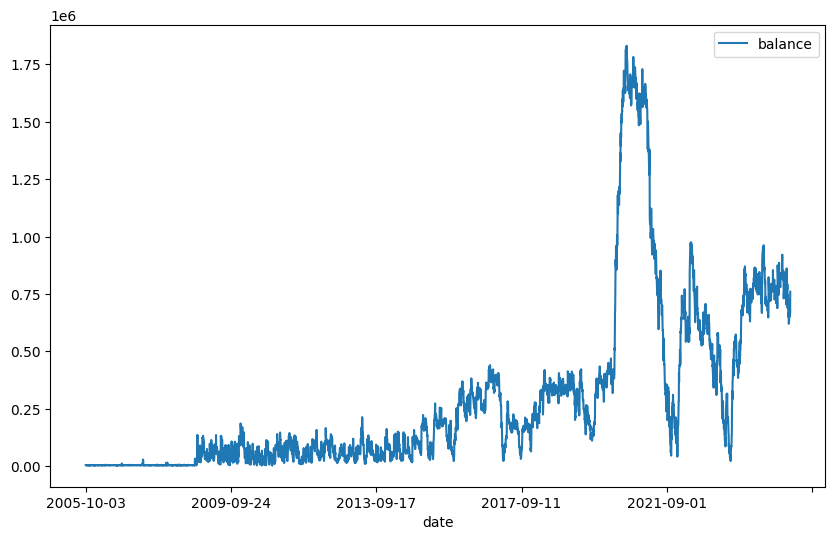

In [31]:
balance.plot(figsize=(10, 6))